### **Importing Libraries**

In [7]:
import os
import cv2
import math
import shutil
import kagglehub
import numpy as np
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
path

100%|██████████| 2.29G/2.29G [00:25<00:00, 96.1MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2'

In [3]:
base_path = os.path.join(path, 'chest_xray', 'chest_xray')
!ls {base_path}

test  train  val


In [4]:
splits = ['train', 'val', 'test']

for split in splits:
    split_path = os.path.join(base_path, split)
    print(f"\nContents of {split_path}:")
    !ls {split_path}


Contents of /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/train:
NORMAL	PNEUMONIA

Contents of /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/val:
NORMAL	PNEUMONIA

Contents of /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray/test:
NORMAL	PNEUMONIA


### **Defining file path**

In [5]:
# Define paths for each split
train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'val')
test_dir = os.path.join(base_path, 'test')
models_dir = os.path.join('/content/drive/MyDrive/')
os.makedirs(models_dir, exist_ok=True)

### **Preparing Data Generators (Without Augmentation)**

In [8]:
# Define image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data Generators without Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Training Generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
    #verbose=1  # Enable verbose logging
)

# Validation Split Generator
validation_split_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

# Test Generator (Reserved for Final Evaluation)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Real Validation Generator (Reserved for Final Evaluation)
real_validation_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### **Verifying Class Indices**

In [9]:
print("Train Class Indices:", train_generator.class_indices)
print("Validation Split Class Indices:", validation_split_generator.class_indices)
print("Test Class Indices:", test_generator.class_indices)
print("Real Validation Class Indices:", real_validation_generator.class_indices)

Train Class Indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Validation Split Class Indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Test Class Indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Real Validation Class Indices: {'NORMAL': 0, 'PNEUMONIA': 1}


### **Visualizing Class Distribution**

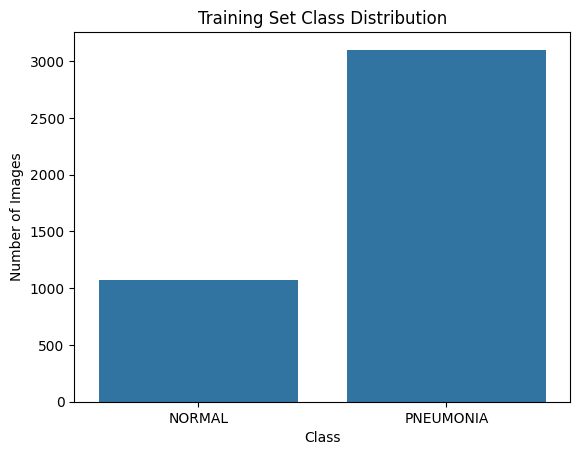

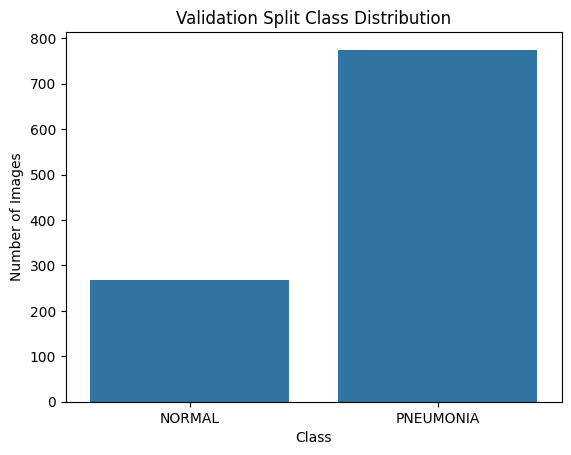

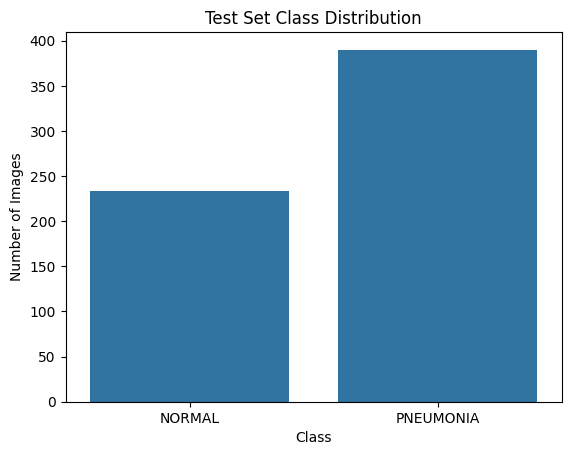

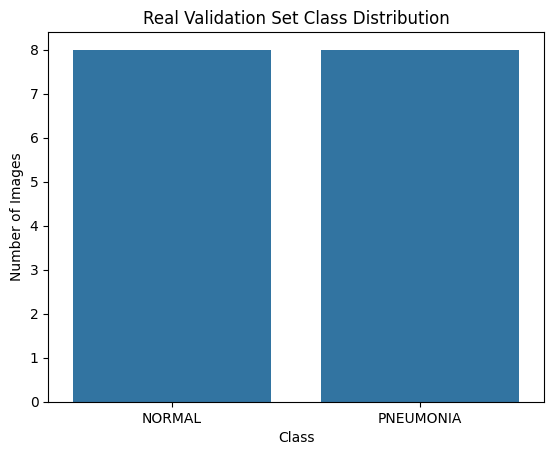

In [10]:
# Plot Class Distribution
def plot_class_distribution(generator, title):
    labels = generator.classes
    class_labels = list(generator.class_indices.keys())
    sns.countplot(x=labels)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(ticks=[0,1], labels=class_labels)
    plt.show()

plot_class_distribution(train_generator, 'Training Set Class Distribution')
plot_class_distribution(validation_split_generator, 'Validation Split Class Distribution')
plot_class_distribution(test_generator, 'Test Set Class Distribution')
plot_class_distribution(real_validation_generator, 'Real Validation Set Class Distribution')

### **Displaying sample images**

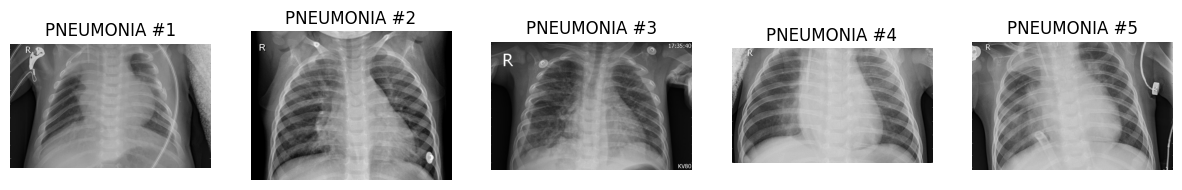

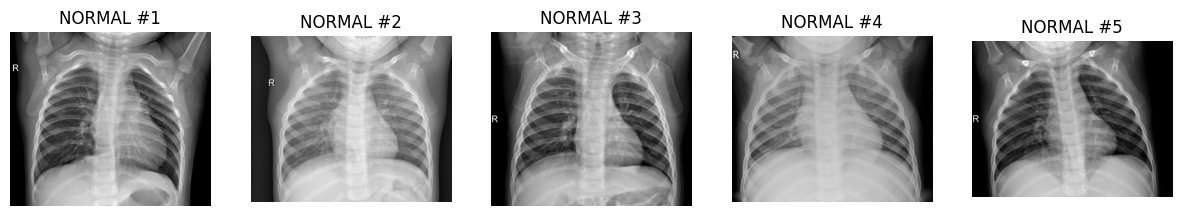

In [11]:
import matplotlib.image as mpimg

def display_sample_images(generator, class_label, num=5):
    class_indices = generator.class_indices
    class_name = [name for name, index in class_indices.items() if index == class_label][0]
    class_dir = os.path.join(generator.directory, class_name)
    images = os.listdir(class_dir)[:num]

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_dir, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, num, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{class_name} #{i+1}")
        plt.axis('off')
    plt.show()

# Display sample Pneumonia images (class label 1)
display_sample_images(train_generator, class_label=1, num=5)

# Display sample Normal images (class label 0)
display_sample_images(train_generator, class_label=0, num=5)

#### **Computing class weight**

In [12]:
# Retrieve the classes from the training generator
classes = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

# Create a dictionary mapping class indices to weights
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.9445479962721341, 1: 0.6730645161290323}


### **IMPORTING MOBILENETV2 FOR TRANSFER LEARNING**
**Model Selection and Building**

In [13]:
def build_transfer_learning_model(input_shape=(224, 224, 3)):
    """
    Builds a transfer learning model using MobileNetV2 as the base.

    Parameters:
    - input_shape: Tuple specifying the input shape of the images.

    Returns:
    - model: The complete Keras model ready for training.
    - base_model: The pre-trained base MobileNetV2 model.
    """
    # Load the MobileNetV2 model, excluding the top layers
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet')

    # Freeze the base model initially
    base_model.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Add dropout for regularization
    x = Dense(128, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model, base_model


In [14]:
# Define image dimensions
IMG_HEIGHT, IMG_WIDTH = 224, 224

# Build the model and get the base_model
model, base_model = build_transfer_learning_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### **Model Training**

In [15]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5, verbose=1)

In [16]:
history = model.fit(
    train_generator,
    epochs=6,
    validation_data=validation_split_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 79s 498ms/step - accuracy: 0.7111 - loss: 0.5754 - val_accuracy: 0.9406 - val_loss: 0.1885 - learning_rate: 1.0000e-04
Epoch 2/6
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 363ms/step - accuracy: 0.9127 - loss: 0.2273 - val_accuracy: 0.9386 - val_loss: 0.1545 - learning_rate: 1.0000e-04
Epoch 3/6
131/131 ━━━━━━━━━━━━━━━━━━━━ 49s 359ms/step - accuracy: 0.9283 - loss: 0.1706 - val_accuracy: 0.9473 - val_loss: 0.1349 - learning_rate: 1.0000e-04
Epoch 4/6
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 364ms/step - accuracy: 0.9415 - loss: 0.1415 - val_accuracy: 0.9703 - val_loss: 0.0926 - learning_rate: 1.0000e-04
Epoch 5/6
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 364ms/step - accuracy: 0.9523 - loss: 0.1205 - val_accuracy: 0.9645 - val_loss: 0.0998 - learning_rate: 1.0000e-04
Epoch 6/6
131/131 ━━━━━━━━━━━━━━━━━━━━ 48s 351ms/step - accuracy: 0.9521 - loss: 0.1182 - val_accuracy: 0.9703 - val_loss: 0.0882 - learning_rate: 1.0000e-04


In [17]:
model.save('model/mobilenetv2_pneumonia_model.h5')

### **Fine Tuning The Model**

In [18]:
def fine_tune_model(model, base_model, fine_tune_at=100):
    """
    Unfreeze the base model and freeze all layers before the specified layer.

    Parameters:
    - model: The compiled Keras model.
    - base_model: The pre-trained base model.
    - fine_tune_at: The layer from which to start fine-tuning.

    Returns:
    - model: The recompiled Keras model ready for fine-tuning.
    """
    # Unfreeze the base model
    base_model.trainable = True

    # Freeze all layers before the 'fine_tune_at' layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Recompile the model with a lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Fine-tune the model
model = fine_tune_model(model, base_model, fine_tune_at=140)

# Define Fine-Tuning Parameters
fine_tune_epochs = 4
total_epochs = 6 + fine_tune_epochs  # Initial epochs + fine-tuning epochs

# Continue Training with Fine-Tuning
history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_split_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)

Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 70s 432ms/step - accuracy: 0.9050 - loss: 0.3118 - val_accuracy: 0.9664 - val_loss: 0.0953 - learning_rate: 1.0000e-06
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 48s 353ms/step - accuracy: 0.9252 - loss: 0.2134 - val_accuracy: 0.9655 - val_loss: 0.1013 - learning_rate: 1.0000e-06
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9128 - loss: 0.2366 - val_accuracy: 0.9597 - val_loss: 0.1065 - learning_rate: 1.0000e-06


### **Plotting Training History**

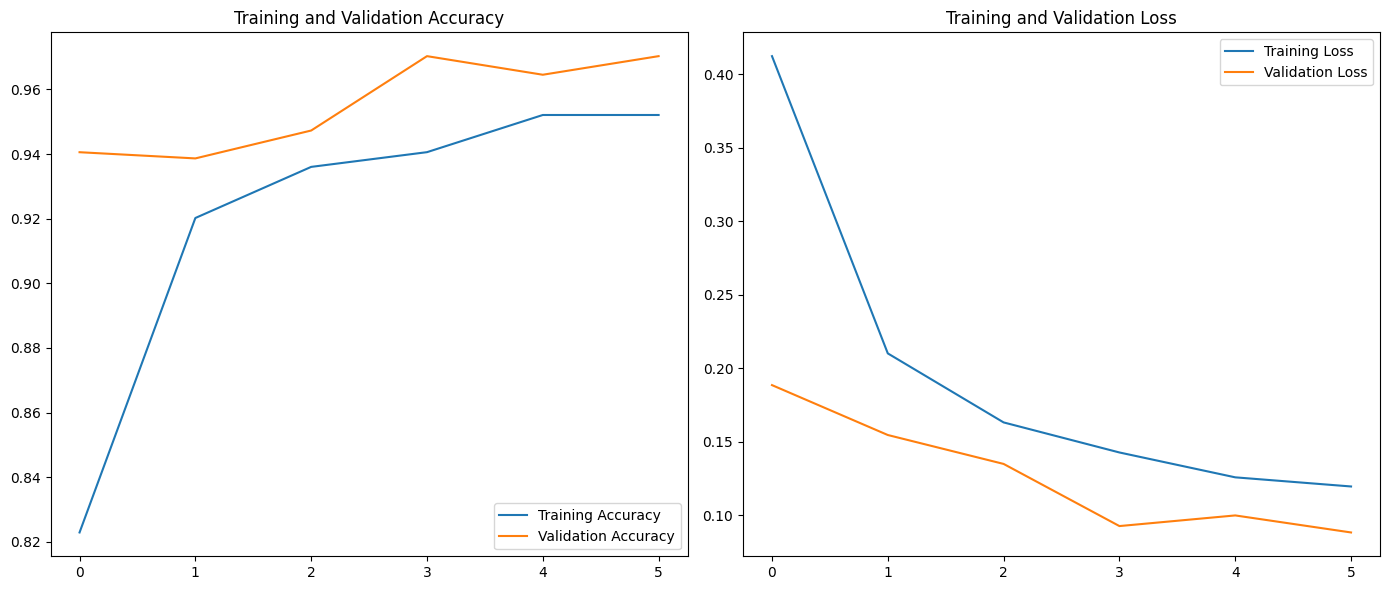

In [19]:
# Plot training & validation accuracy and loss value
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

### **Evaluation**

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step


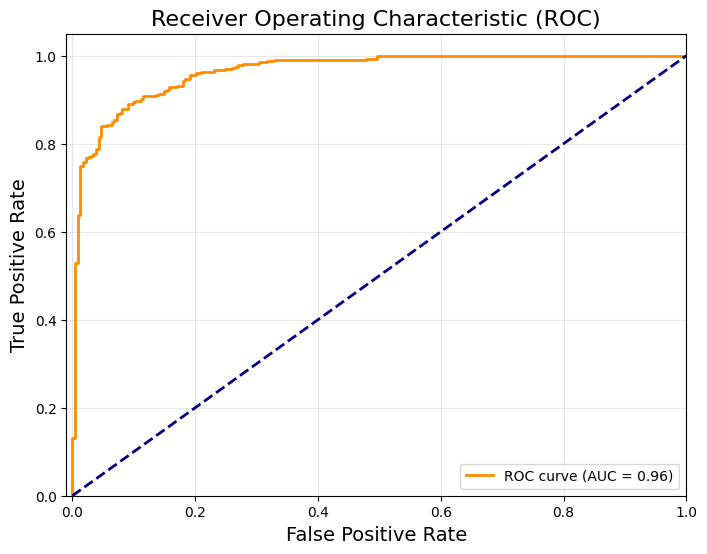

In [26]:
# Predict probabilities
test_generator.reset()  # Ensure generator starts from the beginning
y_pred_prob = model.predict(test_generator, verbose=1)
y_pred = (y_pred_prob > 0.65).astype(int).ravel()

# True labels
y_true = test_generator.classes

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [27]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.70      0.81       234
   PNEUMONIA       0.84      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



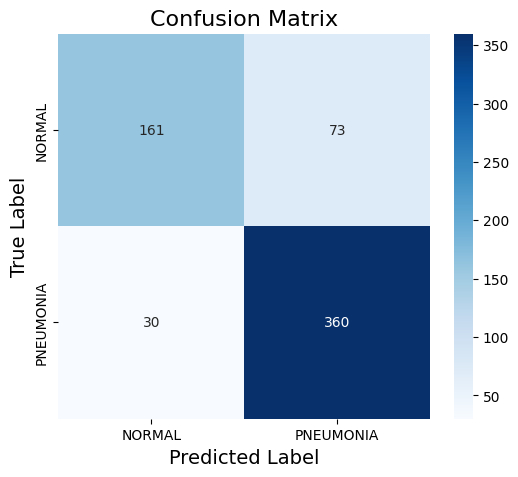

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

### **Saving the model**

In [1]:
print(tf.__version__)

2.17.1


### **Implementing Grad Cam**

In [ ]:
def get_img_array(img_path, size):
    """
    Reads an image from disk and preprocesses it.

    Parameters:
    - img_path: Path to the image file.
    - size: Desired image size (height, width).

    Returns:
    - Preprocessed image array.
    """
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = preprocess_input(array)
    return array

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap.

    Parameters:
    - img_array: Preprocessed image array.
    - model: Trained Keras model.
    - last_conv_layer_name: Name of the last convolutional layer.
    - pred_index: Index of the target class.

    Returns:
    - Heatmap array.
    """
    # Create a model that maps the input image to the activations of the last conv layer
    # and the model's predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute the gradient of the class output value with respect to the feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute the guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by the corresponding gradient importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU to the heatmap to keep only positive values
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    """
    Superimposes the Grad-CAM heatmap on the original image.

    Parameters:
    - img_path: Path to the original image.
    - heatmap: Grad-CAM heatmap.
    - cam_path: Path to save the superimposed image.
    - alpha: Transparency factor for the heatmap overlay.

    Returns:
    - None
    """
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap * alpha + img

    # Save the image
    cv2.imwrite(cam_path, superimposed_img)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img.astype('uint8'))
    plt.axis('off')
    plt.show()


last_conv_layer_name = 'Conv_1'